## 🛳️ Titanic — XGBoost

Projeto de classificação supervisionada para previsão de sobrevivência no Titanic utilizando XGBoost, com foco em modelos baseados em boosting, avaliação estatística rigorosa e seleção objetiva do melhor modelo.

### Destaques

* Pipeline completo com pré-processamento versionado e integração via `Pipeline`.
* Comparação entre Baseline, Random Search, Refine e Otimização Bayesiana.
* Avaliação com validação cruzada 10-fold, ROC-AUC e acurácia.
* Otimização automática de threshold, além do limiar padrão.
* Testes estatísticos (t-test pareado) para validação dos ganhos.
* Relatório técnico automatizado com ranking, vencedor e análise de generalização.




## 1. Bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import time

from scipy.stats import ttest_rel

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

# XGBoost
from xgboost import XGBClassifier

# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic
from src.plot_metrica_class import *


## 2. Dataload & Preprocessamento com joblib

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_Titanic_v1.2.joblib')
PP2=temp['preprocessador']

# # =====================================================
# # 📁 1. Leitura dos dados & Separação das bases
# # =====================================================

DATA_DIR = BASE / "data" / "raw"
X_train = pd.read_csv(DATA_DIR / "X_train_raw.csv").reset_index(drop=True)
X_test  = pd.read_csv(DATA_DIR / "X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_raw.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR / "y_test_raw.csv")


# # =====================================================
# #  🤖 3.Definição dos Modelos
# # =====================================================

# -----------------------
# Baseline
# -----------------------
model_XGB0 = XGBClassifier(objective='binary:logistic',eval_metric='logloss',
                           random_state=42,n_jobs=-1)
pipe_XGB0 = pipe_models(model_XGB0, PP2)

# randomsearch exploratorio
DATA_MODELS= BASE /"models"
pipe_XGB1 = joblib.load(DATA_MODELS / 'modelo_XGB_final_randsearch.accuracy_v12.joblib')
pipe_XGB2 = joblib.load(DATA_MODELS / 'modelo_XGB_final_refine.accuracy_v12.joblib')
pipe_XGB3 = joblib.load(DATA_MODELS / 'modelo_XGB_final_bayes.accuracy_v12.joblib')


## 3.Treinamento

In [3]:
# Baseline
s0 = cross_val_score(pipe_XGB0 , X_train, y_train, cv=10)

# 2. Testa a performance 
pipe_XGB0.fit(X_train, y_train)
# 3.Otimização de Threshold
best_t_xgb0, score_xgb0 = best_threshold(pipe_XGB0, X_test, y_test)

y_pred=pipe_XGB0.predict(X_test)
print(f"{'='*70}")
print(f"🎯 Random Forest (Baseline) | cvscores : {s0.mean():.4f} ± {s0.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.640
📈 Melhor Acurácia (Test): 0.8022
🎯 Random Forest (Baseline) | cvscores : 0.8235 ± 0.0485
📊 Acurácia no Teste: 0.7836

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       157
           1       0.75      0.72      0.73       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.78      0.78      0.78       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         130         27         
Real 1         31          80         
──────────────────────────────────────────────────────────────────────


In [4]:
# XGB1
s1= cross_val_score(pipe_XGB1 , X_train, y_train, cv=10)
# 2. Testa a performance 
pipe_XGB1.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_xgb1, score_xgb1 = best_threshold(pipe_XGB1, X_test, y_test)

y_pred=pipe_XGB1.predict(X_test)
print(f"{'='*70}")
print(f"🎯 XGB 1 | cvscores : {s1.mean():.4f} ± {s1.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.630
📈 Melhor Acurácia (Test): 0.8209
🎯 XGB 1 | cvscores : 0.8411 ± 0.0558
📊 Acurácia no Teste: 0.8172

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       157
           1       0.79      0.76      0.77       111

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         135         22         
Real 1         27          84         
──────────────────────────────────────────────────────────────────────


In [5]:
#XGB 2
s2= cross_val_score(pipe_XGB2 , X_train, y_train, cv=10)
# 2. Testa a performance 
pipe_XGB2.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_xgb2, score_xgb2 = best_threshold(pipe_XGB2, X_test, y_test)

y_pred=pipe_XGB2.predict(X_test)
print(f"{'='*70}")
print(f"🎯 XGB 2 | cvscores : {s2.mean():.4f} ± {s2.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.520
📈 Melhor Acurácia (Test): 0.8358
🎯 XGB 2 | cvscores : 0.8491 ± 0.0494
📊 Acurácia no Teste: 0.8321

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       157
           1       0.81      0.77      0.79       111

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.83      0.83      0.83       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         137         20         
Real 1         25          86         
──────────────────────────────────────────────────────────────────────


In [6]:
#XGB3
s3= cross_val_score(pipe_XGB3 , X_train, y_train, cv=10)

# 2. Testa a performance 
pipe_XGB3.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_xgb3, score_xgb3 = best_threshold(pipe_XGB3, X_test, y_test)

y_pred=pipe_XGB3.predict(X_test)
print(f"{'='*70}")
print(f"🎯 XGB 3 | cvscores : {s3.mean():.4f} ± {s3.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.460
📈 Melhor Acurácia (Test): 0.8209
🎯 XGB 3 | cvscores : 0.8475 ± 0.0408
📊 Acurácia no Teste: 0.8134

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       157
           1       0.80      0.74      0.77       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.81      0.81      0.81       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         136         21         
Real 1         29          82         
──────────────────────────────────────────────────────────────────────


In [7]:

# Calcula os scores de validação cruzada para cada modelo(acc)
s0_acc = cross_val_score(pipe_XGB0, X_train, y_train, cv=10)
s1_acc = cross_val_score(pipe_XGB1, X_train, y_train, cv=10)
s2_acc = cross_val_score(pipe_XGB2, X_train, y_train, cv=10)
s3_acc = cross_val_score(pipe_XGB3, X_train, y_train, cv=10)

score0 = pipe_XGB0.score(X_test, y_test)
score1 = pipe_XGB1.score(X_test, y_test)
score2 = pipe_XGB2.score(X_test, y_test)
score3 = pipe_XGB3.score(X_test, y_test)

y_prob0 = pipe_XGB0.predict_proba(X_test)[:, 1]
y_prob1 = pipe_XGB1.predict_proba(X_test)[:, 1]
y_prob2 = pipe_XGB2.predict_proba(X_test)[:, 1]
y_prob3 = pipe_XGB3.predict_proba(X_test)[:, 1]



# # 1. Preparação dos Dados de Performance
models_list = [
    ('Modelo 0 ( Base )', pipe_XGB0, s0, s0_acc, y_prob0, best_t_xgb0),
    ('Modelo 1 (Random)', pipe_XGB1, s1, s1_acc, y_prob1, best_t_xgb1),
    ('Modelo 2 (Refine)', pipe_XGB2, s2, s2_acc, y_prob2, best_t_xgb2),
    ('Modelo 3 (Bayes )', pipe_XGB3, s3, s3_acc, y_prob3, best_t_xgb3,)
]

df_results,W = gerar_relatorio_estatistico(models_list,X_train, y_train,X_test, y_test)

                      RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA                       
      Modelo         CV ROC-AUC        CV ACC       Test ROC-AUC   Test ACC (0.5)   Best Thresh    Test ACC (Opt)
Modelo 0 ( Base ) 0.8235 ± 0.0485 0.8235 ± 0.0485      0.8520          0.7836          0.640           0.8022    
Modelo 1 (Random) 0.8411 ± 0.0558 0.8411 ± 0.0558      0.8738          0.8172          0.630           0.8209    
Modelo 2 (Refine) 0.8491 ± 0.0494 0.8491 ± 0.0494      0.8749          0.8321          0.520           0.8358    
Modelo 3 (Bayes ) 0.8475 ± 0.0408 0.8475 ± 0.0408      0.8695          0.8134          0.460           0.8209    

                     ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)                     
Modelo 1 (Random) vs Modelo 2 (Refine): p-value = 0.3266 | Diferença Significativa? NÃO
Modelo 1 (Random) vs Modelo 3 (Bayes ): p-value = 0.4049 | Diferença Significativa? NÃO
Modelo 2 (Refine) vs Modelo 3 (Bayes ): p-value = 0.8114 | Di

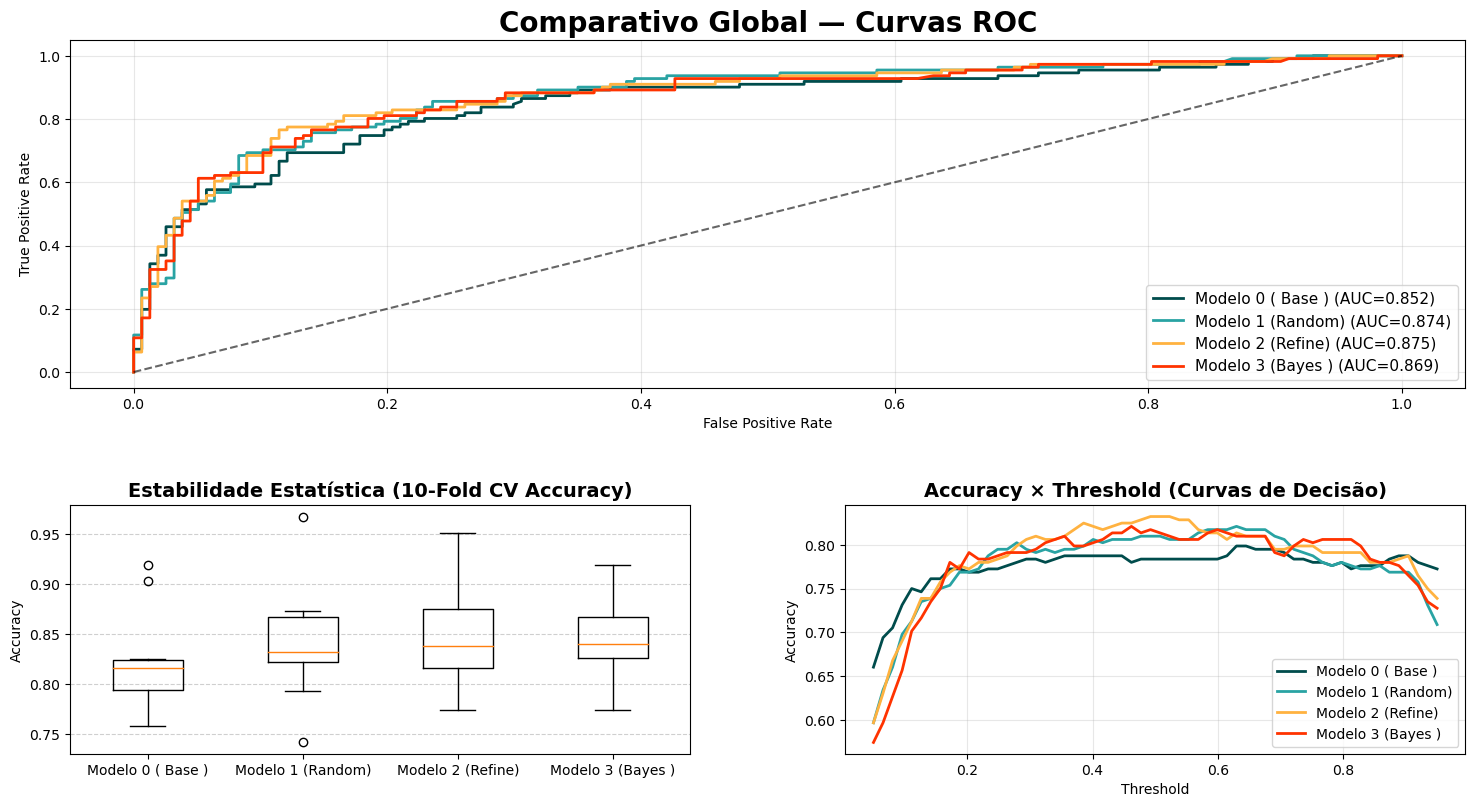

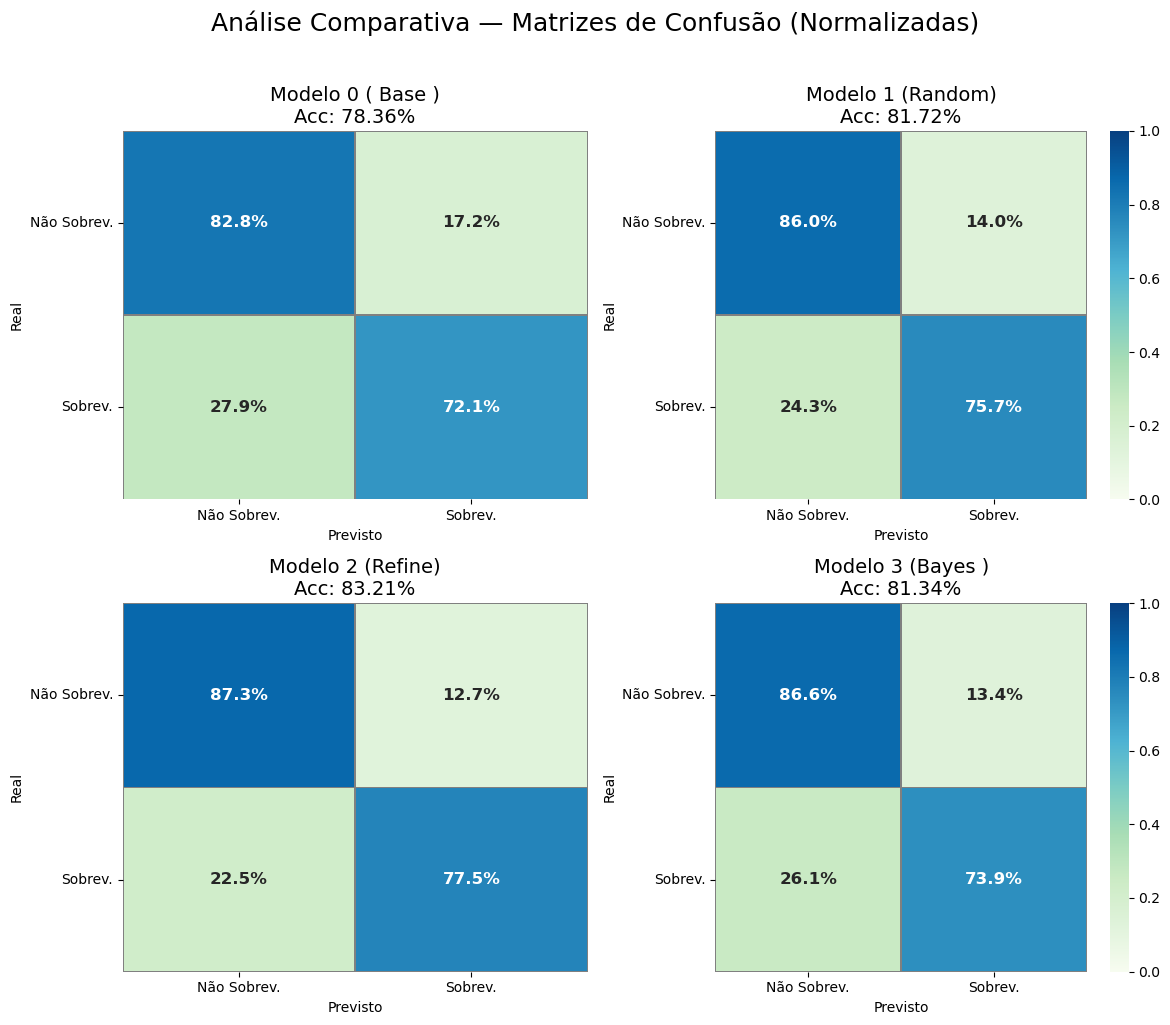

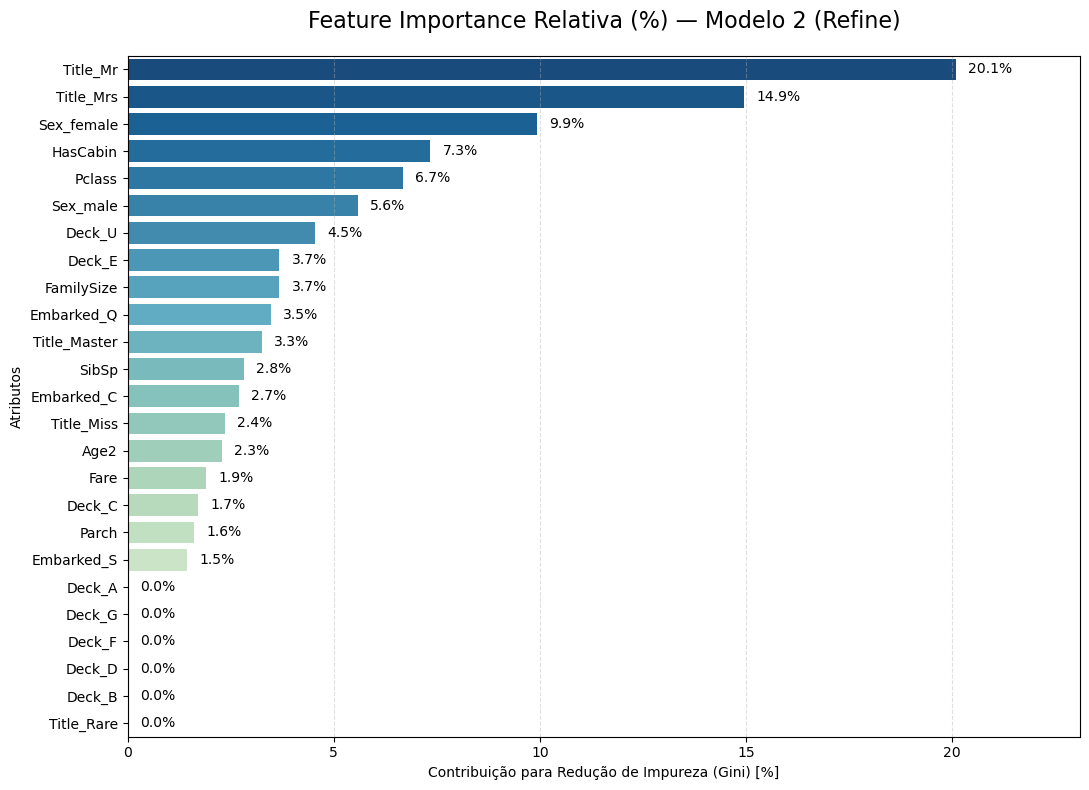


#Processo finalizado em: 16:34:51


In [11]:
#plotagem dos resultados
importances=model_evaluation_grid(
    models_list=models_list,
    X_test=X_test,
    y_test=y_test,
    best_model_pipeline=W[1],
    best_model_name=W[0]
)

## Considerações finais

A análise dos resultados evidencia de forma consistente o impacto da otimização progressiva de hiperparâmetros e do ajuste de threshold no desempenho dos modelos XGBoost aplicados ao problema de classificação do Titanic.

### Síntese dos resultados

* O XGBoost Baseline apresentou desempenho adequado como ponto de partida, com ROC-AUC ≈ 0.82 em validação cruzada e acurácia de teste inferior aos modelos otimizados, indicando limitação na captura de interações mais complexas sem ajuste fino.

* Os modelos otimizados apresentaram ganhos graduais e consistentes:

  * O Modelo 2 (Refine) destacou-se como o melhor modelo global, alcançando ROC-AUC em teste de 0.8749 e acurácia otimizada de 0.8358, superando o baseline de forma estatisticamente significativa.

  * Os modelos Random Search e Bayesiano apresentaram desempenho competitivo, porém sem ganhos adicionais relevantes em relação ao modelo refinado.

### Análise de generalização (validação cruzada)

A comparação entre desempenho médio e variabilidade indica que:

* O Modelo 2 (Refine) oferece o melhor equilíbrio entre performance, estabilidade e generalização, com baixa discrepância entre validação cruzada e teste;

* As diferenças entre os modelos otimizados não são estatisticamente significativas entre si, sugerindo que a maior parte do ganho ocorre nas etapas iniciais de refinamento;

* O XGBoost mostrou-se menos sensível à variabilidade amostral do que modelos baseados exclusivamente em bagging.

### Interpretação e relevância das variáveis

A análise de importância das variáveis confirma padrões coerentes com o contexto do problema:

* Título social, sexo e classe socioeconômica (Pclass) permanecem como os principais fatores associados à sobrevivência;

* Variáveis estruturais como cabine, deck e tamanho da família contribuem de forma complementar;

* A distribuição de importâncias sugere que o modelo captura tanto efeitos dominantes quanto interações secundárias relevantes.

### Conclusões práticas

* O XGBoost com refinamento direcionado de hiperparâmetros é o modelo mais indicado para este conjunto de dados, combinando melhor desempenho em teste, alta estabilidade estatística e boa capacidade de generalização.

* O ajuste de threshold mostrou-se essencial para extrair ganhos reais de acurácia, reforçando a importância de decisões além do ponto de corte padrão.

* Estratégias de otimização mais agressivas não produziram ganhos proporcionais, indicando retorno marginal decrescente após o refinamento intermediário.


### Comparação final entre algoritmos

Apesar do excelente desempenho do XGBoost refinado, a comparação global entre algoritmos indica que o **Random Forest otimizado** apresentou resultados superiores no conjunto de teste, consolidando-se como o modelo vencedor do estudo.

Em termos quantitativos:

* Random Forest otimizado 🏆

  * Test ROC-AUC ≈ 0.89
  * Acurácia otimizada ≈ 0.84
  * Baixa discrepância entre validação cruzada e teste, indicando alta estabilidade.

* XGBoost (Modelo 2 – Refine)

  * Test ROC-AUC = 0.8749
  * Acurácia otimizada = 0.8358
  * Excelente generalização, porém ligeiramente inferior ao Random Forest no desempenho final.

Essa diferença, embora moderada em magnitude, foi consistente nos experimentos, indicando vantagem prática do Random Forest na captura de padrões não lineares neste conjunto de dados específico.

Dessa forma, o XGBoost permanece como uma solução robusta e bem calibrada, enquanto o Random Forest se consolida como a escolha final recomendada, apresentando o melhor equilíbrio entre desempenho, estabilidade estatística e simplicidade operacional.
